In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [12]:
gpp_data = xr.open_dataset("./gpp_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["gpp"]
cveg_data = xr.open_dataset("./cVeg_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["cVeg"]
ts_data = xr.open_dataset("./ts_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["ts"]
hurs_data = xr.open_dataset("./hurs_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["hurs"]
pr_data = xr.open_dataset("./pr_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["pr"]

In [13]:
start_x = 12*(1880-1850)
end_x = 12*(1900-1850)
start_y = 12*(1980-1850)
end_y = 12*(2000-1850)

def avg20(ds):
    return np.mean(ds.to_numpy(), axis=0) # axis of mean = time

In [14]:
x_cveg = avg20(cveg_data[start_x:end_x,:,:])
x_ts = avg20(ts_data[start_x:end_x,:,:])
x_pr = avg20(pr_data[start_x:end_x,:,:])
x_gpp = avg20(gpp_data[start_x:end_x,:,:])
y_ts = avg20(ts_data[start_y:end_y,:,:])
y_pr = avg20(pr_data[start_y:end_y,:,:])
y_gpp = avg20(gpp_data[start_y:end_y,:,:])
y_cveg = avg20(cveg_data[start_y:end_y,:,:])
delta_ts = y_ts - x_ts
delta_pr = y_pr - x_pr
delta_cveg = y_cveg - x_cveg
delta_gpp = y_gpp - x_gpp

mask = x_cveg > 0

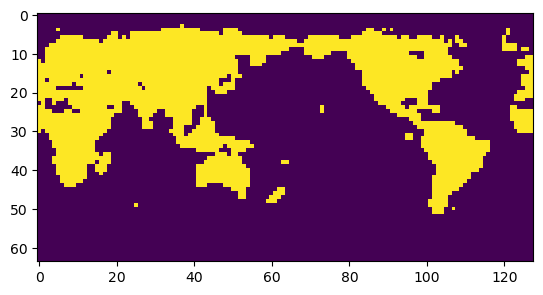

In [5]:
plt.imshow(mask[::-1])

In [15]:
from sklearn.linear_model import LinearRegression

In [104]:
def plot_and_test(input, output, mask,color=None,ax=plt):
    output = output[mask].flatten()
    input = input[mask].flatten()
    
    ax.scatter(input, output, alpha=0.2, color=color)

def fit_and_test(inputs, output, mask, test_inputs, test_output, title=""):
    inputs_c = inputs.copy()
    output_c = output.copy()

    test_inputs_c = test_inputs.copy()
    test_output_c = test_output.copy()
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title)    
    axs[0][0].imshow(output[::-1], vmin=0, vmax=16)
    axs[0][1].imshow(test_output[::-1], vmin=0, vmax=16)  

    axs[0][0].set_ylabel("CanESM")
    axs[1][0].set_ylabel("Predicted")

    axs[0][0].set_title("Historical")
    axs[0][1].set_title("Future")  
    
    output = output[mask].flatten()
    test_output = test_output[mask].flatten()

    output_c = output_c.flatten()
    test_output_c = test_output_c.flatten()
    
    for i in range(len(inputs)):
        inputs[i] = inputs[i][mask].flatten()
        test_inputs[i] = test_inputs[i][mask].flatten()
        inputs_c[i] = inputs_c[i].flatten()
        test_inputs_c[i] = test_inputs_c[i].flatten()
    inputs = np.array(inputs).transpose()
    test_inputs = np.array(test_inputs).transpose()

    inputs_c = np.array(inputs_c).transpose()
    test_inputs_c = np.array(test_inputs_c).transpose()
    
    model = LinearRegression()
    model.fit(inputs, output)

    R2_present = model.score(inputs, output)
    R2_future = model.score(test_inputs, test_output)

    predicted_present = model.predict(inputs_c).reshape(64,128)
    predicted_future = model.predict(test_inputs_c).reshape(64,128)

    predicted_present[~mask] = 0
    predicted_future[~mask] = 0

    axs[1][0].imshow(predicted_present[::-1], vmin=0, vmax=16)
    axs[1][1].imshow(predicted_future[::-1], vmin=0, vmax=16)

    print(predicted_present)
    
    print("*", model.coef_, "+", model.intercept_)
    print("R^2 Present", R2_present)
    print("R^2 Future", R2_future) 
    
    return model

Text(0, 0.5, 'delta cVeg')

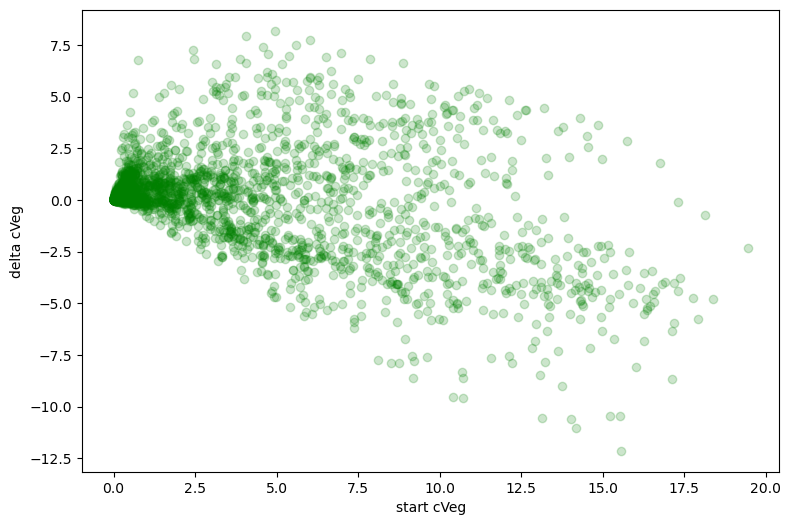

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plot_and_test(x_cveg, delta_cveg, mask, ax=ax, color="g")
ax.set_xlabel("start cVeg")
ax.set_ylabel("delta cVeg")

In [67]:
mask.shape

(64, 128)

Text(0, 0.5, 'Delta Precip.')

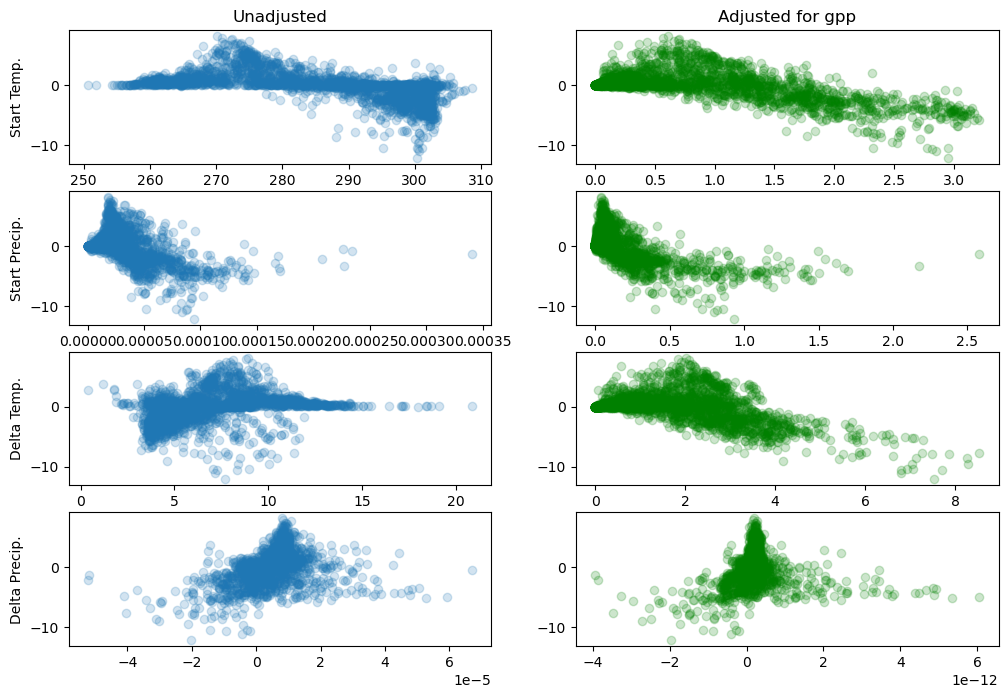

In [47]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8))

fig_d = [
    [x_ts,x_pr,delta_ts,delta_pr],
    [x_ts*x_gpp,x_pr*x_gpp,delta_ts*x_gpp,delta_pr*x_gpp]
]

fig_c = [None, "g"]

for x in (0,1):
    for y in (0,1,2,3):
        plot_and_test(fig_d[x][y], delta_cveg, mask,ax=axs[y][x], color=fig_c[x])
axs[0][0].set_title("Unadjusted")
axs[0][1].set_title("Adjusted for gpp")
axs[0][0].set_ylabel("Start Temp.")
axs[1][0].set_ylabel("Start Precip.")
axs[2][0].set_ylabel("Delta Temp.")
axs[3][0].set_ylabel("Delta Precip.")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
* [1.6270412e-02 1.2169495e+00 3.6068207e+02] + -3.7287393
R^2 Present 0.536144373528517
R^2 Future 0.08389114134752862


LinearRegression()

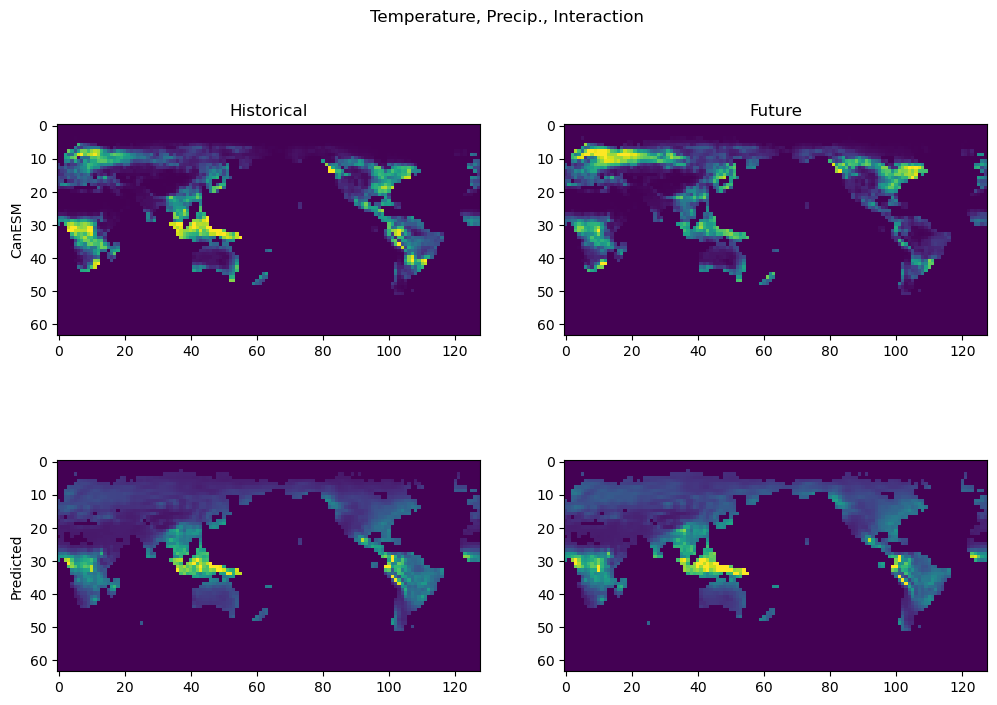

In [114]:
fit_and_test([x_ts, x_pr, x_ts*x_pr], x_cveg, mask, [y_ts, y_pr, y_ts*y_pr], y_cveg, "Temperature, Precip., Interaction")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
* [2.2736937e-02 1.0718954e+05] + -5.646649
R^2 Present 0.5387341294482624
R^2 Future 0.10554464740718994


LinearRegression()

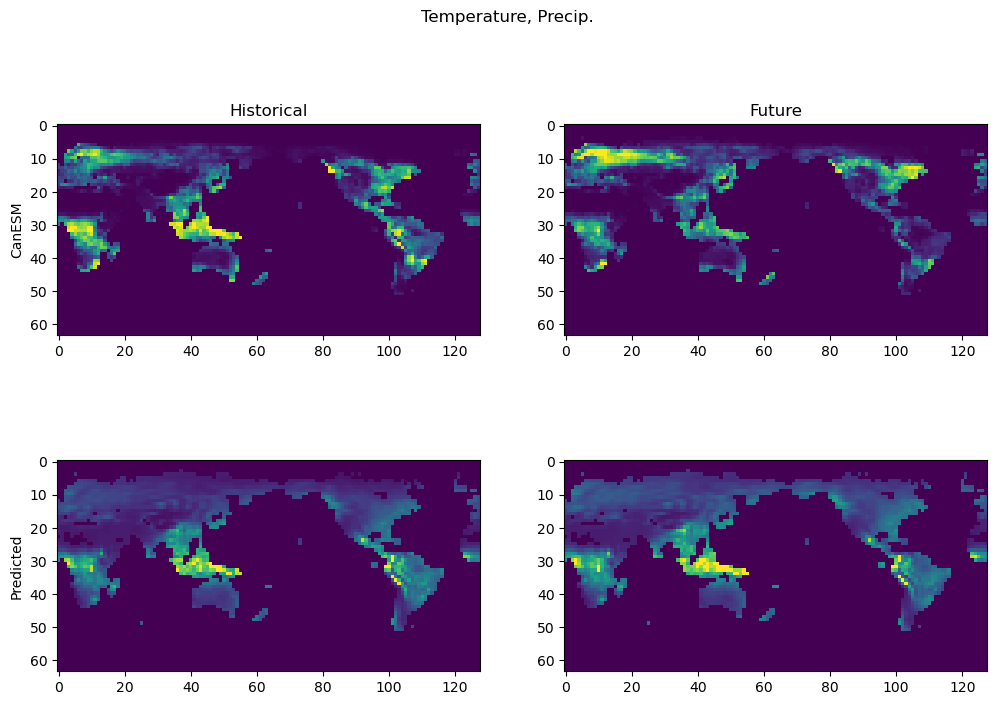

In [113]:
fit_and_test([x_ts, x_pr], x_cveg, mask, [y_ts, y_pr], y_cveg, "Temperature, Precip.")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
* [0.10752989] + -26.603598
R^2 Present 0.1269939450487444
R^2 Future -0.16592806113333358


LinearRegression()

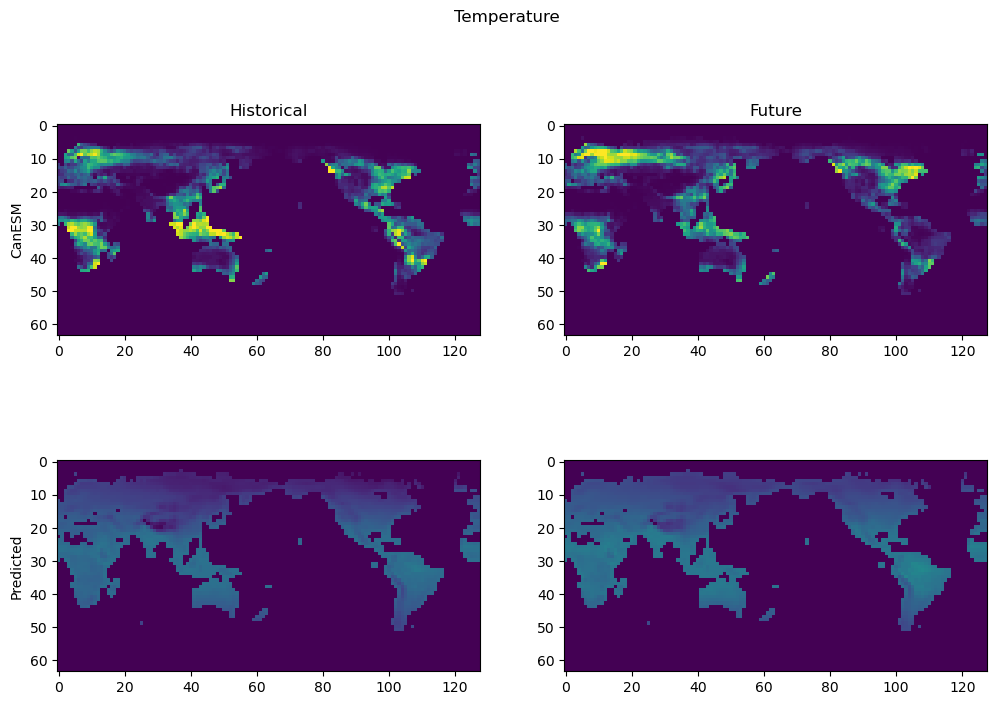

In [109]:
fit_and_test([x_ts], x_cveg, mask, [y_ts], y_cveg, "Temperature")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
* [111815.43] + 0.68574834
R^2 Present 0.533969973310108
R^2 Future 0.13303633712538998


LinearRegression()

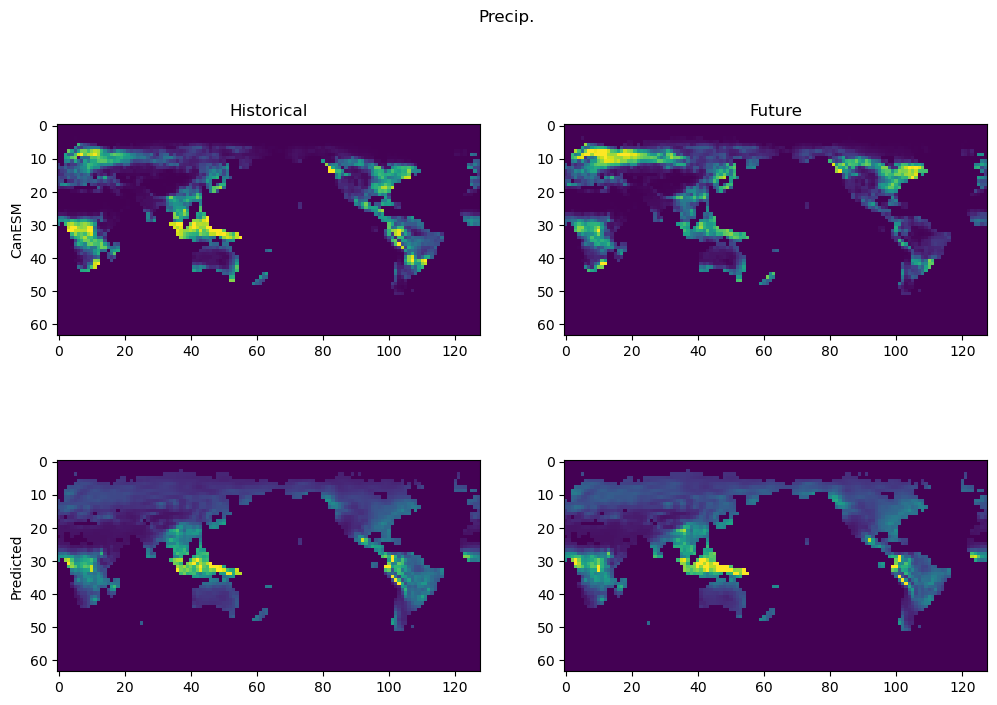

In [108]:
fit_and_test([x_pr], x_cveg, mask, [y_pr], y_cveg, "Precip.")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
* [1.3595118e+08] + -0.08055544
R^2 Present 0.7383391192230242
R^2 Future 0.5612458197438545


LinearRegression()

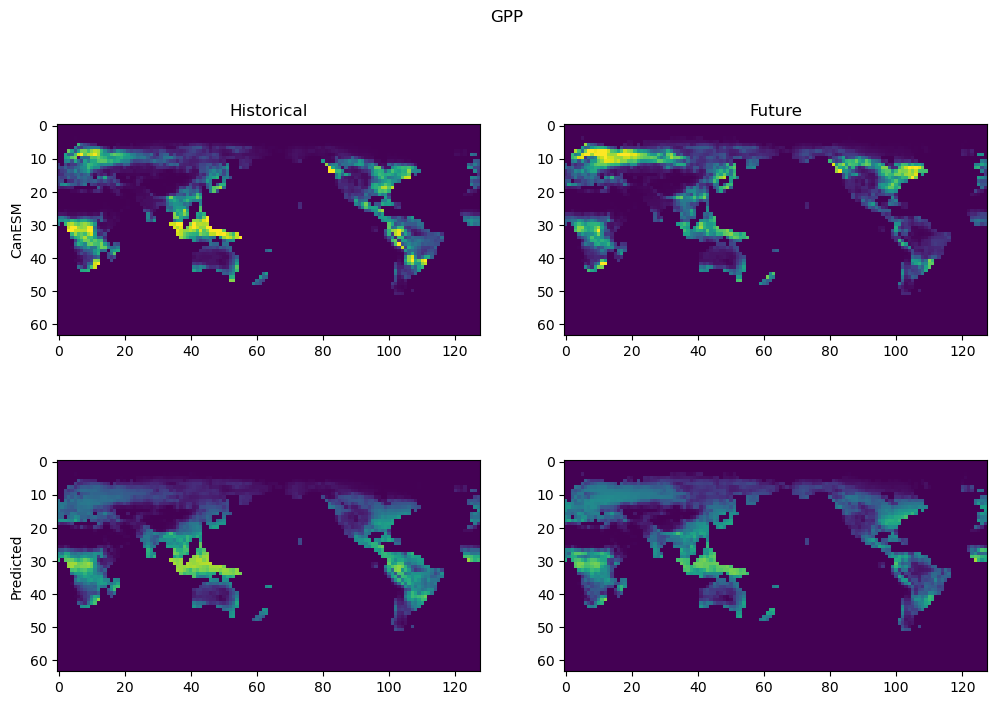

In [112]:
fit_and_test([x_gpp], x_cveg, mask, [y_gpp], y_cveg, "GPP")

In [37]:
fit_and_test([x_gpp, x_ts * x_gpp, x_pr * x_gpp], x_cveg, mask, [y_gpp, y_ts * y_gpp, y_pr * y_gpp], y_cveg)

* [ 1.5766633e+09 -4.9391340e+06  5.0535390e+11] + -0.7899089
R^2 Present 0.8422725620708537
R^2 Future 0.7624604708367346


LinearRegression()

In [25]:
# Choose r to make sphere surface area 1 for easy multiplication later
# r = sqrt(1/4pi)
r = np.sqrt(1/(4*np.pi))

# Gets height of section of sphere given two angles
def getH(angles):
    angle_min = np.min(angles)
    angle_max = np.max(angles)
    
    # Hypotenuse = r
    # Hypotenuse * sin(Theta) = Opposite
    h_min = r * np.sin(angle_min)
    h_max = r * np.sin(angle_max)
    return h_max - h_min

# https://en.wikipedia.org/wiki/Spherical_segment
def getArea(horizontal_angles,vertical_angles,in_degrees=True):
    if in_degrees: # We need radians
        horizontal_angles *= (np.pi / 180)
        vertical_angles *= (np.pi / 180)

    left_bound = np.min(horizontal_angles)
    right_bound = np.max(horizontal_angles)
    arc_horz = right_bound - left_bound

    # 2 * pi * r * h * arc2
    return 2 * np.pi * r * getH(vertical_angles) * (arc_horz/(2*np.pi))

# should theoretically equal 1
getArea(np.array([-180,180], dtype=np.float64),np.array([90,-90], dtype=np.float64))

0.9999999999999999

In [26]:
def cuts(amount_vertical,amount_horizontal,vstart=90):
    space = np.linspace(-vstart,vstart,amount_vertical+1)
    width = 360/amount_horizontal
    y = []
    # We only care about vertical dimension
    for i in range(amount_vertical):
        y.append(getArea(np.array([0,width], dtype=np.float64), np.array([space[i],space[i+1]], dtype=np.float64)))
    x = np.array([y] * amount_horizontal)
    return x.transpose()

#cuts(10,5) # This may be in the wrong orientation but we can always transpose    

In [27]:
weights = cuts(64,128,vstart=90)
gpp_data[0].to_numpy().shape

np.sum(ts_data[0].to_numpy() * weights)

#np.sum(weights * gpp_data[0].to_numpy())

285.41345298253

In [28]:
def timeseries(datamap,colors="rgb",combined=False):
    i = 0
    yearlys = []
    for name, filepath in datamap.items():
        dataset = xr.open_dataset(filepath)
        varname = filepath.split("/")[-1].split("_")[0] #.lower()
        values = dataset[varname].to_numpy()
        weights = cuts(values.shape[1],values.shape[2])

        plt.figure(figsize=(12,4))
        
        values = np.nan_to_num(values)
        monthly = np.sum(values * weights, axis=(1,2))
        yearly = np.mean(monthly.reshape(-1, 12), axis=1)
        yearly_time = dataset["time"][0::12]
        yearlys.append(yearly)
        
        if not combined:
            plt.plot(yearly, color=colors[i%len(colors)])
            plt.title(name)
        i += 1
    if combined:
        plt.plot(np.array(yearlys).transpose())
        plt.legend(datamap.keys())



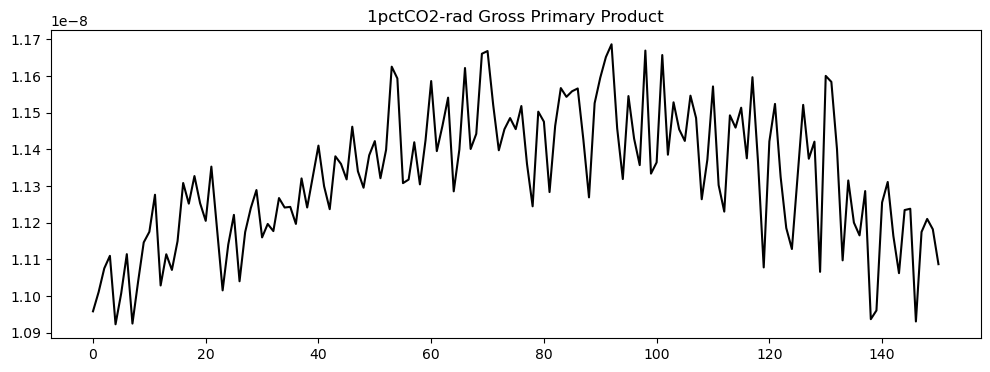

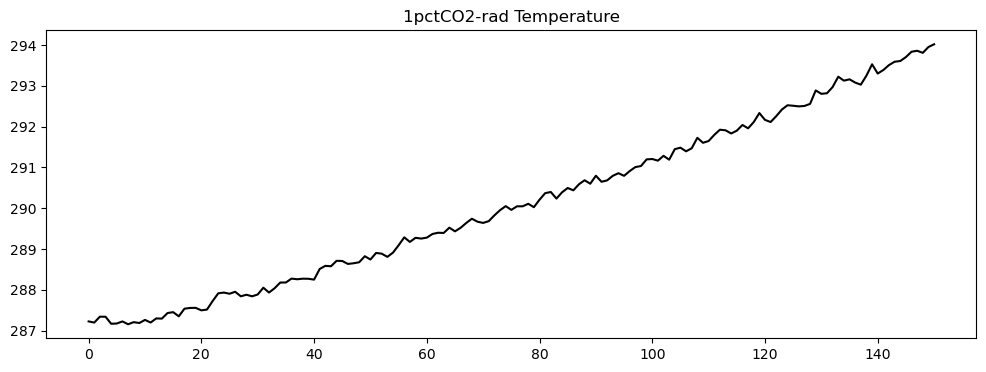

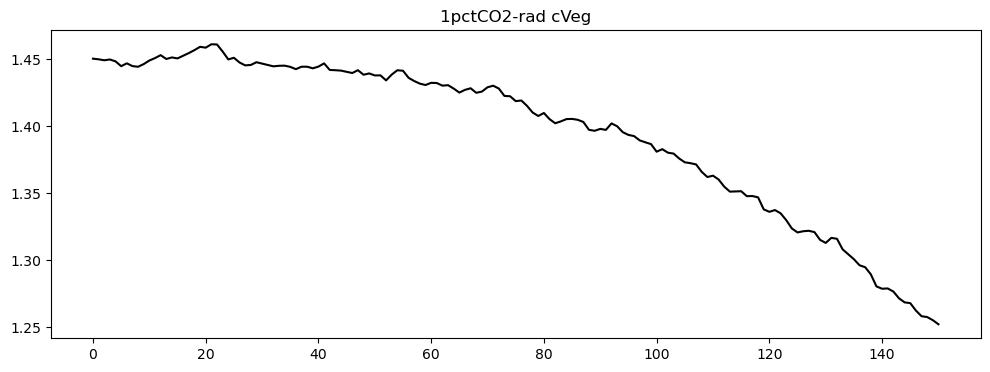

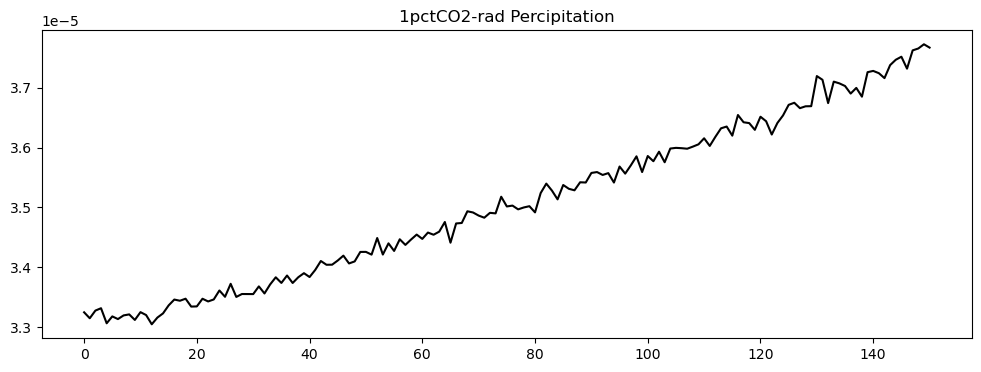

In [29]:
timeseries({
    "1pctCO2-rad Gross Primary Product":"./gpp_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2-rad Temperature":"./ts_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2-rad cVeg":"./cVeg_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2-rad Percipitation":"./pr_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc",
}, colors=["black"])

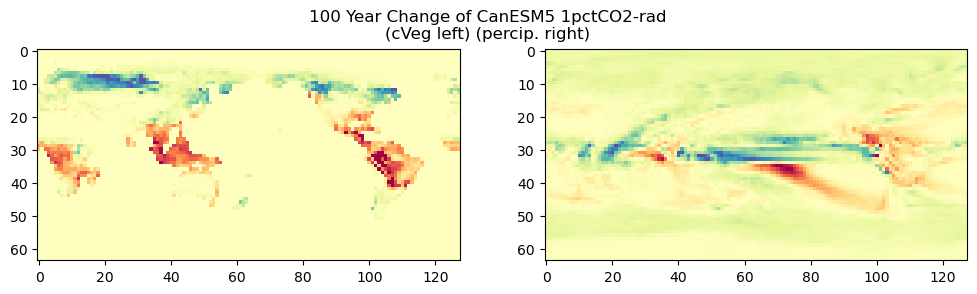

In [30]:

def procedure(cveg_f, pr_f, name):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,3))
    fig.suptitle('100 Year Change of ' + name + '\n(cVeg left) (percip. right)')
    
    xf_cveg = avg20(cveg_f[start_x:end_x,:,:])
    yf_cveg = avg20(cveg_f[start_y:end_y,:,:])
    deltaf_cveg = yf_cveg - xf_cveg
    spectral_plot(deltaf_cveg, ax=ax1)

    xf_pr = avg20(pr_f[start_x:end_x,:,:])
    yf_pr = avg20(pr_f[start_y:end_y,:,:])
    deltaf_pr = yf_pr - xf_pr
    spectral_plot(deltaf_pr, ax=ax2, r=0.00005)

def spectral_plot(content, r=7, c="Spectral", ax=plt):
    ax.imshow(content[::-1], cmap=c, vmin=-r, vmax=r)

procedure(xr.open_dataset("./cVeg_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["cVeg"],
         xr.open_dataset("./pr_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["pr"],
          "CanESM5 1pctCO2-rad"
)

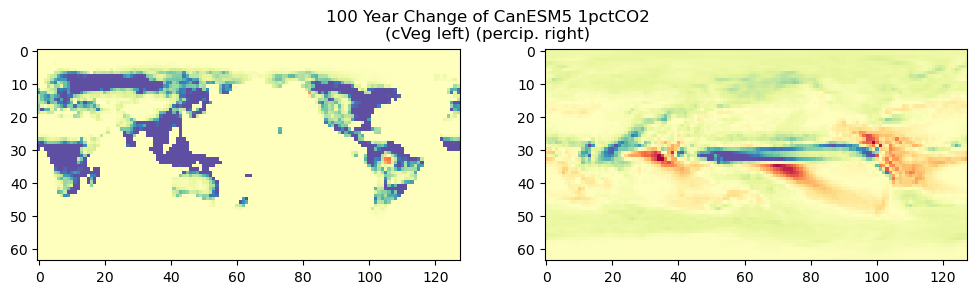

In [31]:
procedure(xr.open_dataset("./cVeg_Lmon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["cVeg"],
         xr.open_dataset("./pr_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["pr"],
          "CanESM5 1pctCO2"
)

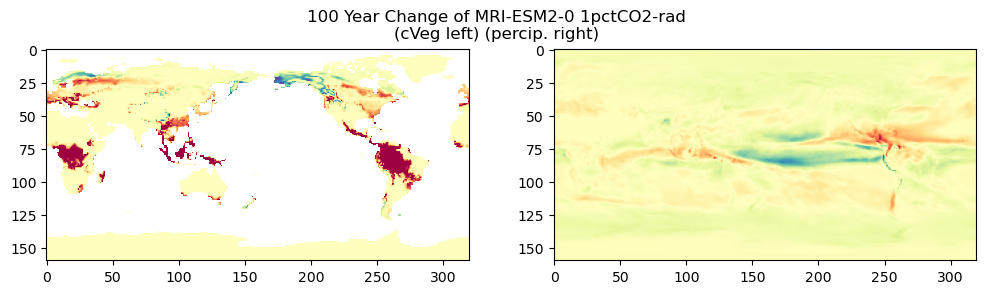

In [32]:
procedure(xr.open_dataset("./cVeg_Lmon_MRI-ESM2-0_1pctCO2-rad_r1i2p1f1_gn_185001-200012.nc")["cVeg"],
         xr.open_dataset("./pr_Amon_MRI-ESM2-0_1pctCO2-rad_r1i2p1f1_gn_185001-200012.nc")["pr"],
          "MRI-ESM2-0 1pctCO2-rad"
)

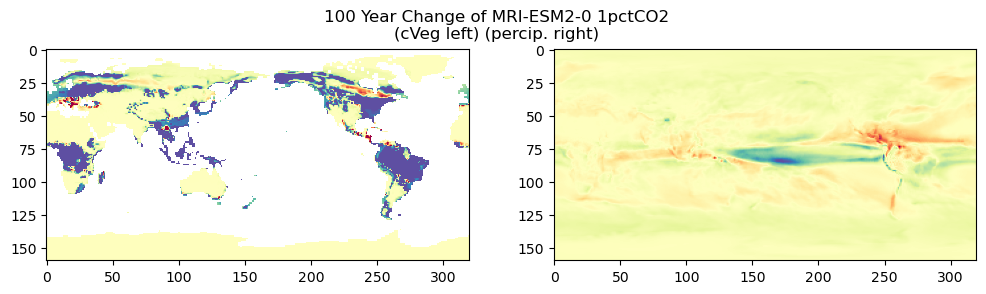

In [33]:
procedure(xr.open_dataset("./cVeg_Lmon_MRI-ESM2-0_1pctCO2_r1i2p1f1_gn_185001-200012.nc")["cVeg"],
         xr.open_dataset("./pr_Amon_MRI-ESM2-0_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["pr"],
          "MRI-ESM2-0 1pctCO2"
)

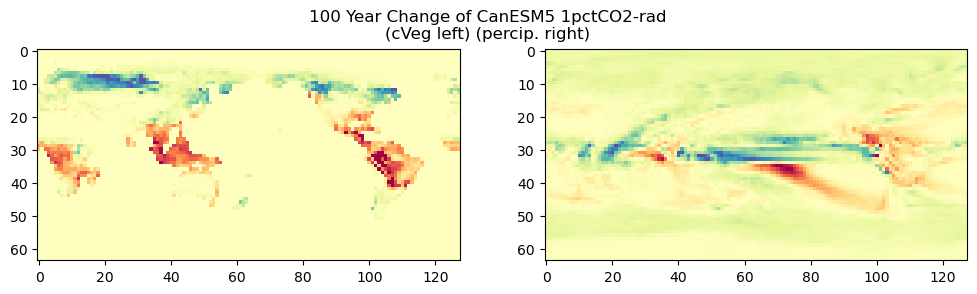

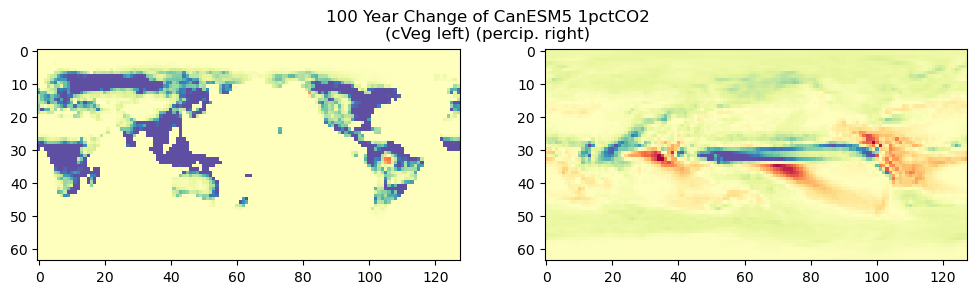

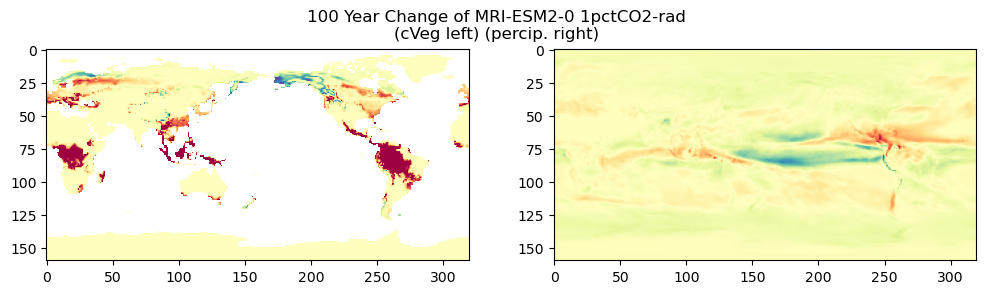

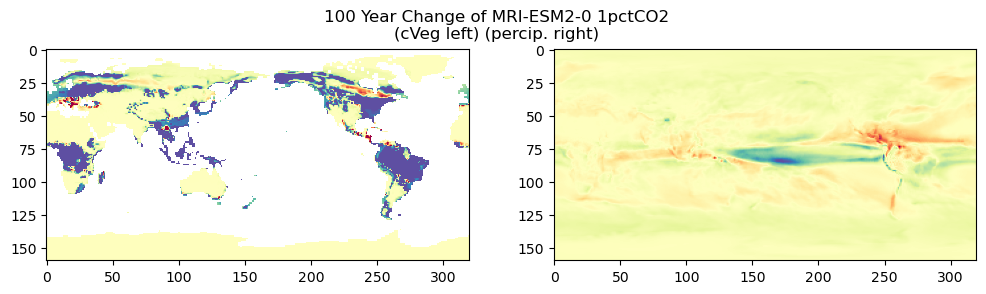

In [35]:
procedure(xr.open_dataset("./cVeg_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["cVeg"],
         xr.open_dataset("./pr_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["pr"],
          "CanESM5 1pctCO2-rad"
)

procedure(xr.open_dataset("./cVeg_Lmon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["cVeg"],
         xr.open_dataset("./pr_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["pr"],
          "CanESM5 1pctCO2"
)

procedure(xr.open_dataset("./cVeg_Lmon_MRI-ESM2-0_1pctCO2-rad_r1i2p1f1_gn_185001-200012.nc")["cVeg"],
         xr.open_dataset("./pr_Amon_MRI-ESM2-0_1pctCO2-rad_r1i2p1f1_gn_185001-200012.nc")["pr"],
          "MRI-ESM2-0 1pctCO2-rad"
)

procedure(xr.open_dataset("./cVeg_Lmon_MRI-ESM2-0_1pctCO2_r1i2p1f1_gn_185001-200012.nc")["cVeg"],
         xr.open_dataset("./pr_Amon_MRI-ESM2-0_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["pr"],
          "MRI-ESM2-0 1pctCO2"
)